### 0. Import the packages

In [1]:
import os,sys,shutil,mmap
import pickle as pickle
import numpy as np                                       # fast vectors and matrices
import matplotlib.pyplot as plt                          # plotting
from scipy.fftpack import fft

import time
from sklearn.metrics import average_precision_score
import tensorflow as tf
import mir_eval

sys.path.insert(0,'lib/')
import config
import model_functions_norm2 as model_functions_norm # contains self-written functions

from versions_norm import version_dicc

%matplotlib inline


### 1. Pick the version

In [2]:
vers = "190322_LSTM_pt"

for key, value in version_dicc[vers].items():
    print(f'{key:21}', ": ", value)

if "pt" in vers:
    PRETRAIN = True
    pretrain = version_dicc[vers]["pretrained"]
    print("\nUse pretrained weights")
else:
    PRETRAIN = False
#model_functions.test_import("Import successful.")

debugging = False

graph                 :  <function LSTM_PT_graph_MomOpt_noReg at 0x7fd8af4717b8>
pretrained            :  190319_11HZ
window                :  4096
timesteps             :  9
stride                :  256
kk                    :  256
dd                    :  1024
d2_x                  :  1
d2_y                  :  128
k2                    :  128
stride_y              :  2
d3_x                  :  13
d3_y                  :  1
k3                    :  1024
num_units             :  1024
starter_learning_rate :  0.001
decay_steps           :  10000
lr_decay              :  0.95
mom                   :  0.95
max_steps             :  99999
comment               :  use pretrained weights, try more timesteps and bigger LSTM-Unit

Use pretrained weights


### 2. Import the data
Import the recording and labels of the 331 recordings from the data base.

#### 2.1 Import the labels of the data set.
The 331 labels are saved in a dictionary whose
- keys are integers (the ids of the recordings)
- values are intervaltrees (for the different intervals of the recording it gives the played notes between 1 and 128)

In [3]:
with open(config.labels_path_11, 'rb') as f:
    labels = pickle.load(f)

#### 2.2 Import recordings

Create a dictionary containing the data (recordings). Use Memory-mapped file objects.
For each recording data[rec_id] is a tuple:
1. data[rec_id][0] is the memory-mapped file object to the recording. It can be accesed by 
~~~~~~
np.frombuffer(data[rec_id][0], dtype=np.float32).copy()
~~~~~~
2. data[rec_id][1] is its length (float)

In [4]:
data = dict()
for record in os.listdir(config.records_path_11_new):
    fd = os.open(config.records_path_11_new + record, os.O_RDONLY)
    buff = mmap.mmap(fd, 0, mmap.MAP_SHARED, mmap.PROT_READ)
    data[int(record[:-4])] = (buff, len(buff)/model_functions_norm.sz_float)
    os.close(fd)
    

#### 2.3 Split up in the test and train set

In [5]:
extended_test_set = True
use_mirex = True

# use the small or big test set
if extended_test_set:
    test_ids = config.test_ids_ext
else:
    test_ids = config.test_ids

# include the mirex dev set in test results
if use_mirex:
    test_ids = test_ids + config.mirex_id

train_ids = [rec_id for rec_id in labels.keys() if rec_id not in test_ids]

if debugging == True:
    train_ids = [rec_id for rec_id in train_ids if rec_id not in model_functions_norm.delete_ids]

print('There are {} samples in the test set'.format(len(test_ids)))
print('There are {} samples in the train set'.format(len(train_ids)))
    
#model_functions_norm.get_mean_std(train_ids, data)
    

There are 11 samples in the test set
There are 320 samples in the train set


#### 2.4 Calculate mean and Standard Deviation

The mean is approximatly 0 and standard deviation 1. Therefore, no normalization is applied.

In [6]:
#_,_ = model_functions_norm.mean_std(data, train_ids)

### 3. Preprocessing

The input data (recordings) are normalized and the possible note range is defines to 128 notes. The lowest note is ..., the highest ... .

In [7]:
# Normalize the recordings
normalize = True
# Possible notes are from range [base_note, base_note + m)
base_note = 0
mm = 128

#### 3.1 Data augmentation

Always make two small changes to input data by randomly stretching or shrinking our input audio that are not noticable by human hearing, but augment the data set:
1. Pitch-shift in the frequency domain: Randomly  shifting  each data points in a minibatch by an integral number of semitones. This reinforces the architectural structure of the translation-invariant network.
2. Jittering: continuous shift to each data point. This makes the models more robust to tuning variation between recordings --> regularization

Define a function for extracting a sequence and its label as well as applying the data augmentation.

In [8]:
# pitching: stretching or shrinking our input audio with linear interpolation
pitch_transforms=5 # =/- 5 semitones
jitter=.1

Pitch-shifting corresponds to a multiplication by $2^{1/12}$ (an octave is equal to 12 semitones and corresponds to a factor 2 in the frequency domain) for each semirone.

A scaling factor in the frequency domain implies also a scaling factor in the time domain. (speeding up the recording $\to$ higher frequency $\to$ sounds higher.

All these methods are applied in the function 
~~~~~~
model_functions.get_data(rec_id, timesteps, s, window, pitch_shift, scaling_factor, normalize=True)
~~~~~~

#### 3.2 Batch-selection
Create the training batch applying the above explained methods for Data augmentation utilizing the function
~~~~~~
model_functions.get_training_batch(model_stats, batch_size, timesteps, window, pitch_transforms=0, jitter=0, normalize=True)
~~~~~~

#### 3.3 Creation of Training and Test set for protocolling

Routines that create sample for the protcoling:
1. Routine to obtain the training samples given the recording IDs of the training samples.
   -> If sample with same settings already got created and was saved to file it is loaded from numpy.
   -> Else: create the sample by taking at most 100 samples for each recording. Save it to file.
   
  ~~~~~~
  model_functions.get_training_sample(rec_ids, timesteps, d=16384, normalize=True)
  ~~~~~~
   
2. Routine to obtain test samples given the recording IDs of the test samples.
   -> If sample with same settings already got created and was saved to file it is loaded from numpy.
   -> Else: create the sample by taking at most 1000 samples for each recording. Save it to file.
   ~~~~~~
   model_functions.get_test_sample(rec_ids, window, count, timesteps, fixed_stride=-1, pitch_shift=0, normalize=True)
   ~~~~~~
   
### 4. Prepare Protocolling
Save the results, losses, precicions and weights at each protocol point in a diccionary, that is created and updated using the class 
~~~~~~
model_results
~~~~~~

### 5. Error measures
Define the error measures for comparing the correct labeling Y with the extimated labeling Y_hat.
Both labelings are of size (mm) for each segment. The errors are calculated at each protocol point for the training and the test set.
1. Mean Squared Error: When applying the model to a sequence or sequences the mean squared error is calculated directly by applying the tensorflow function.
~~~~~~~~~~~~~~~~~~~~~
tf.reduce_mean(tf.nn.l2_loss( Y_hat - Y ))
~~~~~~~~~~~~~~~~~~~~~
2. Average Precision: The average precision is calculated with the metric function from the sklear package.
~~~~~~~~~~~~~~~~~~~~~
sklearn.metrics.average_precision_score
~~~~~~~~~~~~~~~~~~~~~

### 6. Define the graph

Define batch size (batch_size segments at each training step). Also define a small factor wscale to scale the weights. Regularization can be avoided.

In [9]:
batch_size=150
if debugging == True:
    batch_size = 2
out = 1

#### 6.1 Define layers

#### First layer: 

Lenth of the input (segment) is window=16384. Compute a strided convolution with a d=4096-sample recptive field and a stride=512 sample stride. Since every segment has 16384 samples there are 25 regions for each frame.

After the convolution for each region a filterbank computation is calculated. 
As a filter a log-spaced filterbank is chosen (k=512 sine and cosine filters with logarithmically spaced frequencies from 50 hz to 6000 hz) which is going to be applied to all the regions of the convolution of size d=4096.
The filterbank is created by 
~~~~~~
model_functions.create_filters(d,k)
~~~~~~

#### Second layer:
A convolution is applied along the log-frequency axis opening up a third channel dimension.

#### Third layer:
Convolution along the log-frequency axis. Filters of height 1 are used that fully connect along the time and channel axes of Layer 2

In [10]:
##### variables for input layer

# input size of segment, predict notes played at midpoint of segment
window = version_dicc[vers]["window"]

# number of timesteps to be considered for memory cell
timesteps = version_dicc[vers]["timesteps"]

# size of regions that outputs the convolution from layer one (receptive field)
dd = version_dicc[vers]["dd"]

#stride for first layer convolution --> 13 regions
stride = version_dicc[vers]["stride"]

# variables for filterbank (= first layer)
# number of nodes in first layer (by filterbank get from dd nodes to kk nodes)
kk = version_dicc[vers]["kk"]
wsin,wcos = model_functions_norm.create_filters(dd,kk)

##### variables for second layer
d2_x = version_dicc[vers]["d2_x"]           # lvl2 input dims_x
d2_y = version_dicc[vers]["d2_y"]           # lvl2 input dims_y
k2 = version_dicc[vers]["k2"]               # num lvl2 filters
stride_y = version_dicc[vers]["stride_y"]   # lvl2 stride

##### variables for third layer
d3_x = version_dicc[vers]["d3_x"]           # lvl3 input dims_x
d3_y = version_dicc[vers]["d3_y"]           # lvl3 input dims_y (fully connected)
k3 = version_dicc[vers]["k3"]               # num lvl3 filters

#### variables for LSTM-cell
num_units = version_dicc[vers]["num_units"]

Calculate the sizes of nodes at each layer and the first layer filterbank.

In [11]:
num_regions, num_regions2_x, num_regions2_y, num_regions3_x, num_regions3_y = \
model_functions_norm.calc_region_sizes(window, dd, stride, kk, d2_x, d2_y, stride_y, d3_x, d3_y)

First layer regions: (13,256)
Second layer regions: (13,65)
Third layer regions: (1,65)


#### 6.2 Define tf.Graph()
Set it all together and define the graph.

Define:
- the starter leraning rate
- learning rate decay
- number of steps after which learning rate decay is applied
- the L2-regularization weight
- the Momentum for the tf.train.MomentumOptimizer

For evaluation not the trained weights, but its moving averages with decay 0.9998 are utilized. The shadow variables are maintained by tf.train.ExponentialMovingAverage. In the block for evaluating the direct model their values are retrieved.

In [12]:
# initialize diccionary to save results
model_stats = model_functions_norm.model_results(test_ids, train_ids, labels, data, base_note, mm)

tf.set_random_seed(999)

starter_learning_rate = version_dicc[vers]["starter_learning_rate"]  # starter leraning rate
decay_steps = version_dicc[vers]["decay_steps"]                      # steps until learning rate decay
lr_decay = version_dicc[vers]["lr_decay"]                            # learning rate decay
mom = version_dicc[vers]["mom"]                                      # Momentum for Optimizer
beta_reg = 0                                                         # L2-regularization weight


if PRETRAIN:
    graph, training_op, loss, global_step,lr,reg,y_pd,direct_loss,xb,yb,xd,yd,saver,w,wavg,w2,w2avg,beta,betaavg = \
                                    version_dicc[vers]["graph"] (
                                                model_stats, batch_size, window, timesteps, 
                                                stride, out, wsin, wcos, 
                                                d2_x, d2_y, k2, stride_y, 
                                                d3_x, d3_y, k3, num_regions3_x, num_regions3_y, num_units,
                                                starter_learning_rate, decay_steps, lr_decay)
else:   
    graph, training_op, loss, global_step, lr, reg, y_pd, direct_loss, xb, yb, xd, yd, saver = \
                                    version_dicc[vers]["graph"] (
                                                model_stats, batch_size, window, timesteps, 
                                                stride, out, wsin, wcos, 
                                                d2_x, d2_y, k2, stride_y, 
                                                d3_x, d3_y, k3, num_regions3_x, num_regions3_y, num_units,
                                                starter_learning_rate, decay_steps, lr_decay)


---- Weights ----
w <tf.Variable 'parameters/w:0' shape=(1, 128, 1, 128) dtype=float32_ref>
w2 <tf.Variable 'parameters/w2:0' shape=(13, 1, 128, 1024) dtype=float32_ref>
beta <tf.Variable 'parameters/beta:0' shape=(66560, 128) dtype=float32_ref>
w_proj <tf.Variable 'parameters_train/w_proj:0' shape=(2048, 128) dtype=float32_ref>

---- Layers ----
zx Tensor("model/add:0", shape=(?, 1, 13, 256), dtype=float32)
z2 Tensor("model/Relu:0", shape=(?, 128, 13, 65), dtype=float32)
z3 Tensor("model/Relu_1:0", shape=(?, 1024, 1, 65), dtype=float32)
y_feed_forward Tensor("model/MatMul:0", shape=(1350, 128), dtype=float32)

---- LSTM-Cell ----
Number of units: 1024
Shape of input: (150, 9, 128)
Shape of output: 2 x (150, 1024)
y_output: Tensor("model/MatMul_1:0", shape=(150, 128), dtype=float32)


#### 6.3 Evaluation of the graph

For the aplication of the neuronal network a moving average of the weights is used. Therefore, a different function for evaluation is used.

Inside the function 
~~~~~~
model_functions.predict_direct_model(sess, X, Y) 
~~~~~~
the mean squared error is calculated directly.

### 7. Training

In [13]:
num_steps = version_dicc[vers]["max_steps"]+1
control_step = 1000

if debugging == True:
    num_steps = 5
    control_step = 1

gpu_memory_growth = False

# arrays for input data (batch)
xmb = np.empty([timesteps*batch_size,1,window,1],dtype=np.float32)
ymb = np.empty([timesteps*batch_size,1,mm],dtype=np.float32)


if PRETRAIN:
    pretrained = tf.train.Saver({'w':w,'wavg':wavg,'w2':w2,'w2avg':w2avg,'beta':beta,'betaavg':betaavg})

In [14]:
with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    ptime = time.time()
    tfconfig = tf.ConfigProto()
    tfconfig.gpu_options.allow_growth=gpu_memory_growth
    init_op = tf.global_variables_initializer()
    sess = tf.Session(config=tfconfig)
    
    if PRETRAIN:
        pretrained.restore(sess, 'models/model_'+pretrain+'/model-'+str(version_dicc[pretrain]["max_steps"]))
        print("Model restored.")
           
    sess.run(init_op)
    
    print ('iter\t test_squ_loss\t test_avg_prec\t',
           'train_squ_loss\t train_avg_prec\t',
           'regularization\t time (in s)')
    for step in range(num_steps):
       
        xmb, ymb = model_functions_norm.get_training_batch(model_stats, batch_size, timesteps, window, 
                                      pitch_transforms, jitter)
        
        # every 1000-nd step save the results           
        if step%control_step==0:
            # training step 
            # to check output the loss (save the loss but you cannot compare it with the mse_train)
            _, np_loss, np_global_step, np_lr, reg_np = \
            sess.run([training_op, loss, global_step, lr, reg], 
                                     feed_dict={xb: xmb, yb: ymb})
            
            #print("training step done")
            # A) run model on test set
                        
            # 1. get the test set
            X,Y = model_functions_norm.get_test_sample(model_stats, timesteps, window, 1000, debugging=debugging)

            Y = Y[:,base_note:base_note+mm] # in general without effect
            # shape Xtest: (1000*len(test_ids), timesteps, 1, 16384, 1)   -> (11000, 5, 1, 16384, 1)
            # shape Ytest: (1000*len(test_ids), 128)
            # extended test-set: 11 samples

            
            # 2. prediction of output and calculation of
            # - MSE
            # - average precision
            Y_p, mse_test = model_functions_norm.predict_direct_model(sess, y_pd, direct_loss, xd, yd, X, Y)
            avp_test = average_precision_score(Y.flatten(), Y_p.flatten())
            del X,Y,Y_p
            
            # B) run model on training set
            
            # 1. get training sample
            X,Y = model_functions_norm.get_training_sample(model_stats, timesteps, window, debugging=debugging) #10-20 seconds
            Y = Y[:,base_note:base_note+mm] # in general without effect
            # shape Xtrain: (100*len(train_ids), timesteps, 1, 16384, 1)   -> (32000, 5, 1, 16384, 1)
            # shape Ytrain: (100*len(train_ids), 128)
            # train-set: 320 samples
            
            # 2. prediction of output and calculation of
            # - MSE
            # - average precision
            Y_p, mse_train = model_functions_norm.predict_direct_model(sess, y_pd, direct_loss, xd, yd, X, Y) #110-120 seconds
            avp_train = average_precision_score(Y.flatten(), Y_p.flatten()) 
            
            del X,Y,Y_p
            
            # c) Print the temporary results
            print (np_global_step,'\t', round(mse_test,8),
                    '\t', round(avp_test,8),
                    '\t', round(mse_train,8),
                    '\t', round(avp_train,8),
                    '\t', round(reg_np,8),
                    '\t', round(time.time() - ptime,8))
            
            #D) Save the temporary results
            model_stats.stats['iter'][2].append(np_global_step)
            # protocol learning rate
            model_stats.stats['lr'][2].append(np_lr)
            # protocol runtime
            model_stats.stats['time'][2].append(time.time() - ptime)
            # protocol weights and its norms
            weight_norms = dict()
            for name, weight in model_stats.weights.items():
                weight_norms[name] = np.mean(np.linalg.norm(weight.eval(session=sess),axis=0))
            for name, norm in weight_norms.items():
                model_stats.stats['n'+name][2].append(norm)
            # protocol training errors     
            model_stats.stats['mse_train_1'][2].append(np_loss)
            model_stats.stats['mse_train'][2].append(mse_train)
            model_stats.stats['avp_train'][2].append(avp_train)
            # protocol test errors
            model_stats.stats['mse_test'][2].append(mse_test)
            model_stats.stats['avp_test'][2].append(avp_test)
            ptime = time.time()            
                   
        else:
            #training step 
            _ = sess.run([training_op], feed_dict={xb: xmb, yb: ymb})
            
        if step/num_steps==0.5 or (step+1)/num_steps==1:
            saver.save(sess, 'models/model_'+vers+'/model', global_step=step)
                                
    print ('\nTRAINING DONE')

Initialized
INFO:tensorflow:Restoring parameters from models/model_190319_11HZ/model-149999
Model restored.
iter	 test_squ_loss	 test_avg_prec	 train_squ_loss	 train_avg_prec	 regularization	 time (in s)
1 	 13.18313729 	 0.05280126 	 97.89511505 	 5.912e-05 	 120.67827 	 63.0394268
1001 	 10.69451646 	 0.48306763 	 0.16975219 	 0.53858495 	 110.63314 	 273.34225583
2001 	 10.34700216 	 0.49372473 	 0.11702802 	 0.56319306 	 108.410904 	 232.17761898
3001 	 10.05900031 	 0.49507636 	 0.10410093 	 0.57097936 	 112.15851 	 233.26622963
4001 	 9.87731335 	 0.50289139 	 0.09904309 	 0.57550912 	 118.21121 	 233.77083516
5001 	 9.645758 	 0.50606043 	 0.0936597 	 0.59166182 	 128.5632 	 232.23883772
6001 	 9.41237712 	 0.5112112 	 0.08982135 	 0.5922323 	 137.80467 	 233.74261212
7001 	 9.09859399 	 0.5184459 	 0.08947814 	 0.58516509 	 144.84178 	 240.550138
8001 	 8.84999459 	 0.52224673 	 0.08332106 	 0.60346727 	 149.12273 	 233.76279521
9001 	 8.67375325 	 0.52769099 	 0.08055906 	 0.6

95001 	 7.58913076 	 0.60066228 	 0.12810239 	 0.67344961 	 255.7249 	 233.08738899
96001 	 7.51473546 	 0.60562079 	 0.11843301 	 0.67606466 	 256.70346 	 233.57630944
97001 	 7.56614211 	 0.60071388 	 0.1336378 	 0.67289428 	 256.90967 	 233.3524754
98001 	 7.56241515 	 0.60401771 	 0.1658953 	 0.66938631 	 258.03296 	 233.2935226
99001 	 7.52503132 	 0.60589801 	 0.12144655 	 0.67836046 	 258.89725 	 234.59221125

TRAINING DONE


In [15]:
# save diccionary to have a look at outputs at other times
model_functions_norm.save_obj(model_stats.stats, 'results/'+vers+'_stats')

### 8. Post Processing
#### 8.1 Plots

Plot leraning rate, possibly runtime, errors, precision and norms

In [16]:
results_stats = model_functions_norm.load_obj('results/'+vers+'_stats')

# size of plots
plot_characteristics = {'width': 20, 'height': 13, 'fontsize': 24, 'control_step': 1000, 'savefig': False}

plt.rcParams['xtick.labelsize']=plot_characteristics['fontsize']
plt.rcParams['ytick.labelsize']=plot_characteristics['fontsize']

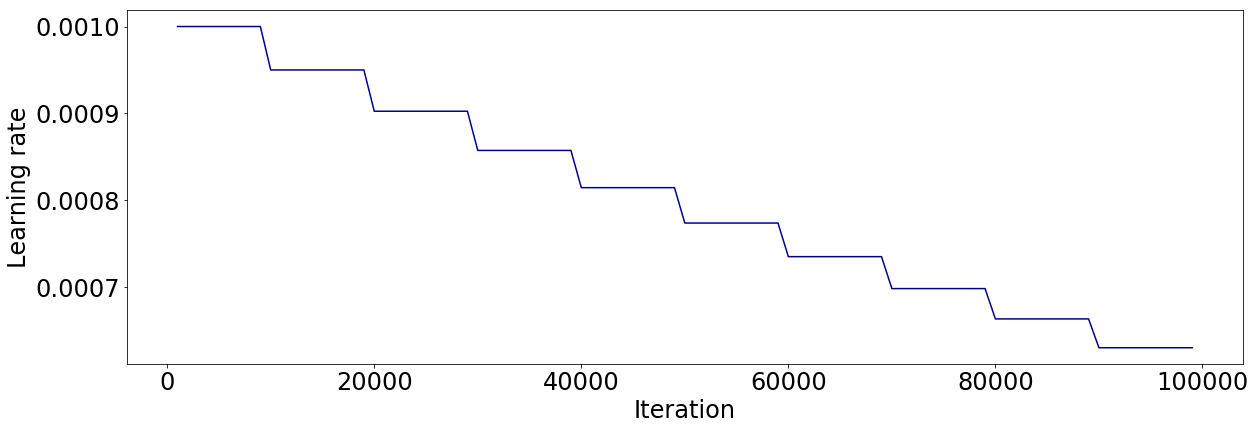

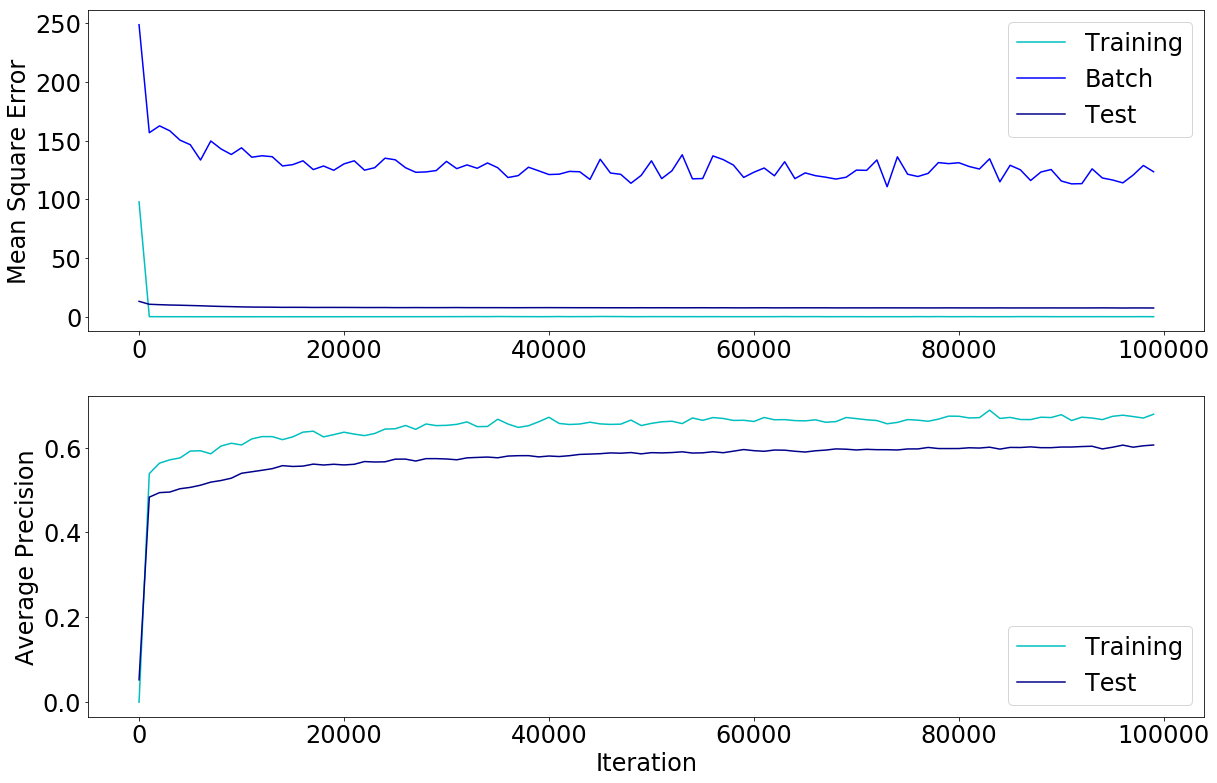

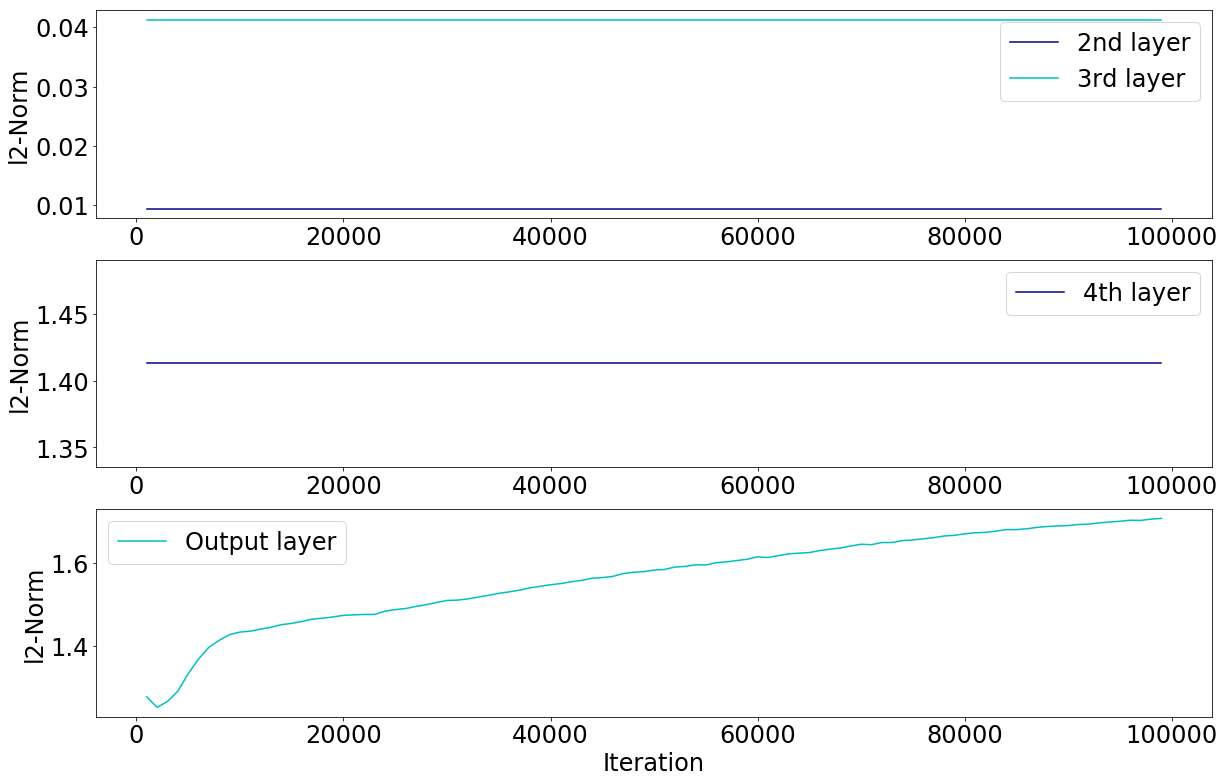

In [17]:
################################################################
# learning rate
model_functions_norm.plot_lr(results_stats, plot_characteristics, vers)

################################################################
# error and precision
model_functions_norm.plot_err_prec(results_stats, plot_characteristics, vers)

################################################################
# norms of the weights
if "LSTM" not in vers:
    model_functions_norm.plot_norms(results_stats, plot_characteristics, vers)
else:
    model_functions_norm.plot_norms_lstm(results_stats, plot_characteristics, vers)

#### 8.2 Mirex Statistics

Statistics that are necesarry for evaluation. The autuor used a threshold of 0.4 for calculation of error etc...

First, restore the model and calculate the output to the test sample:

In [18]:
tf.reset_default_graph()

num_steps = version_dicc[vers]["max_steps"]
timesteps = version_dicc[vers]["timesteps"]



# Later, launch the model, use the saver to restore variables from disk, and
# do some work with the model.
with tf.Session(graph=graph) as sess:
    # Restore variables from disk.
    saver.restore(sess, 'models/model_'+vers+'/model-'+str(num_steps))
    print("Model restored.")

    # 1. get the test set
    X, Y = model_functions_norm.get_test_sample(model_stats, timesteps, window, 1000)
    Y = Y[:,base_note:base_note+mm] # in general without effect
    # shape Xtest: (1000*len(test_ids), 1, window, 1)
    # shape Ytest: (1000*len(test_ids), 128)
    # extended test-set: 11 samples

    # 2. prediction of output
    Y_p, mse_test = model_functions_norm.predict_direct_model(sess, y_pd, direct_loss, xd, yd, X, Y)


INFO:tensorflow:Restoring parameters from models/model_190322_LSTM_pt/model-99999
Model restored.


With the output of the test sample predicted calculate the mirex statistics:

Average Precision (not from mireval), Precision, Recall, Accuracy, Total Error, Substitution, Miss, False Alarm

In [19]:
print('Thr\tAvgP\tP\tR\tAcc\tETot\tESub\tEmiss\tEfa')
for th in [.3, .35,.4, .45, .5]:
    #print("When using threshold",th)
    avp,P,R,Acc,Etot = model_functions_norm.mirex_statistics(Y, Y_p, th)

Thr	AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
0.30	60.521	54.626	63.994	0.418	0.684	0.207	0.153	0.324
0.35	60.521	58.306	58.326	0.412	0.642	0.192	0.225	0.225
0.40	60.521	62.079	53.098	0.401	0.626	0.167	0.302	0.157
0.45	60.521	65.461	47.291	0.378	0.637	0.140	0.387	0.110
0.50	60.521	68.884	41.574	0.350	0.660	0.112	0.472	0.075
